In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
from darts.models import TFTModel

from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

## Observed Data

,Monthly Anamoly
DateTime,
1979-01-01,0.432
1979-02-01,0.269
1979-03-01,5.226
1979-04-01,10.048
1979-05-01,15.546


Text(0.5, 1.0, 'Seoul Temp')

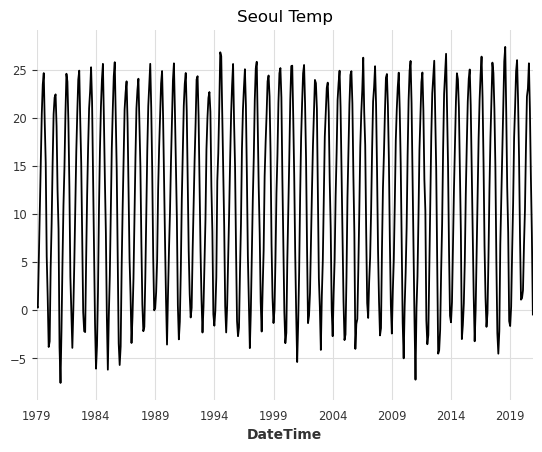

In [3]:
# city_num 0 is Seoul
rawdata = pd.read_csv("../data/all_cities_month_temp_df.csv")
rawdata = rawdata.loc[rawdata.loc[:,"city_num"] == 0]

rawdata["DateTime"] = rawdata["year"].astype('str') + '-' + rawdata["month"].astype('str')
rawdata = rawdata.loc[:,["DateTime", "Monthly Anamoly"]]
rawdata["DateTime"] = pd.to_datetime(rawdata["DateTime"])

train_data = rawdata.loc[rawdata['DateTime'] >= '1979-01-01']
train_data.set_index("DateTime", inplace=True, drop=True)
display(train_data.head())

train_data["Monthly Anamoly"].plot()
plt.title("Seoul Temp")

In [4]:
seoul_timeseries = TimeSeries.from_dataframe(train_data).astype(np.float64)
y_scaler = Scaler()

train_scaled = y_scaler.fit_transform(seoul_timeseries)
train_scaled

<TimeSeries (DataArray) (DateTime: 504, component: 1, sample: 1)> Size: 4kB
array([[[0.22855915]],

       [[0.22389   ]],

       [[0.3658837 ]],

       [[0.50401031]],

       [[0.661501  ]],

       [[0.80048697]],

       [[0.88845603]],

       [[0.92205672]],

       [[0.77525064]],

       [[0.65491263]],

...

       [[0.40896591]],

       [[0.51412203]],

       [[0.69899742]],

       [[0.85236322]],

       [[0.8763678 ]],

       [[0.95121742]],

       [[0.8163277 ]],

       [[0.61366371]],

       [[0.44505872]],

       [[0.20363793]]])
Coordinates:
  * DateTime   (DateTime) datetime64[ns] 4kB 1979-01-01 ... 2020-12-01
  * component  (component) object 8B 'Monthly Anamoly'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Future known data

In [5]:
CO2 = pd.read_csv("Future_Known/SSP2_CO2_data.csv")
POPUL = pd.read_csv("Future_Known/Population_data.csv")
POPUL = POPUL.loc[POPUL['ds'] >= '1979-01-01']
POPUL = POPUL.loc[POPUL['ds'] <= '2100-01-01']

display(CO2)
display(POPUL)

known_input = CO2.merge(POPUL)
known_input['ds'] = pd.to_datetime(known_input['ds'])
known_input.set_index('ds', inplace=True)

,ds,CO2_emission
0,1979-01-01,336.560000
1,1979-02-01,337.290000
2,1979-03-01,337.880000
3,1979-04-01,338.320000
4,1979-05-01,338.260000
...,...,...
1448,2099-09-01,787.469107
1449,2099-10-01,788.054385
1450,2099-11-01,788.659173
1451,2099-12-01,789.244452


,ds,population
348,1979-01-01,4.365583e+09
349,1979-02-01,4.365583e+09
350,1979-03-01,4.365583e+09
351,1979-04-01,4.365583e+09
352,1979-05-01,4.365583e+09
...,...,...
1796,2099-09-01,1.036027e+10
1797,2099-10-01,1.036027e+10
1798,2099-11-01,1.036027e+10
1799,2099-12-01,1.036027e+10


In [6]:
known_input_timeseries = TimeSeries.from_dataframe(known_input)
known_input_timeseries

<TimeSeries (DataArray) (ds: 1453, component: 2, sample: 1)> Size: 23kB
array([[[3.36560000e+02],
        [4.36558300e+09]],

       [[3.37290000e+02],
        [4.36558300e+09]],

       [[3.37880000e+02],
        [4.36558300e+09]],

       ...,

       [[7.88659173e+02],
        [1.03602700e+10]],

       [[7.89244452e+02],
        [1.03602700e+10]],

       [[7.89849240e+02],
        [1.03493230e+10]]])
Coordinates:
  * ds         (ds) datetime64[ns] 12kB 1979-01-01 1979-02-01 ... 2100-01-01
  * component  (component) object 16B 'CO2_emission' 'population'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [7]:
covariate_scaler = Scaler()
known_scaled = covariate_scaler.fit_transform(known_input_timeseries)
known_scaled.astype('float64')

<TimeSeries (DataArray) (ds: 1453, component: 2, sample: 1)> Size: 23kB
array([[[0.00482997],
        [0.        ]],

       [[0.00643264],
        [0.        ]],

       [[0.00772795],
        [0.        ]],

       ...,

       [[0.99738728],
        [0.98835086]],

       [[0.99867222],
        [0.98835086]],

       [[1.        ],
        [0.98654602]]])
Coordinates:
  * ds         (ds) datetime64[ns] 12kB 1979-01-01 1979-02-01 ... 2100-01-01
  * component  (component) object 16B 'CO2_emission' 'population'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Modeling

In [8]:
from darts.utils.callbacks import TFMProgressBar

In [9]:
TFT_params = {
    # hyperparameters for data preparation 
    "input_chunk_length": 120,
    "output_chunk_length": 60,

    # time series hyperparameters 
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    
    # Hyperparameters for model architecture
    "use_static_covariates": True,
    "hidden_size": 16,
    "lstm_layers": 4,
    "num_attention_heads": 4,

    # Hyperparameters for optimization
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 60,
    "random_state": 156,
    "optimizer_kwargs": {"lr": 1e-3},

    "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
}

tft_model = TFTModel(**TFT_params)

In [10]:
tft_model.fit(train_scaled,
            future_covariates=known_scaled,
            verbose=False)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/envs/Torch_practice/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwor

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=4, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=120, output_chunk_length=60, batch_size=16, n_epochs=60, random_state=156, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x31cc0f5e0>]})

In [11]:
scaled_pred = tft_model.predict(12*79, future_covariates=known_scaled)
pred = y_scaler.inverse_transform(scaled_pred)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/envs/Torch_practice/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


<Axes: xlabel='DateTime'>

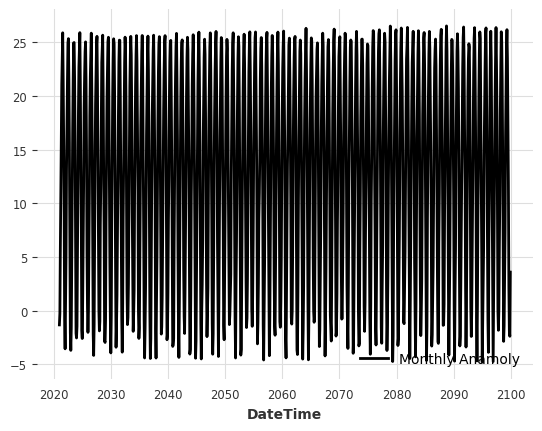

In [12]:
pred.plot()

In [13]:
pred.to_csv('a.csv')
forecast = pd.read_csv("a.csv").set_index("DateTime", drop=True)
forecast

,Monthly Anamoly
DateTime,
2021-01-01,-1.323571
2021-02-01,-0.240191
2021-03-01,5.490120
2021-04-01,10.226060
2021-05-01,15.727380
...,...
2099-08-01,11.961209
2099-09-01,2.140991
2099-10-01,-1.905056


In [14]:
rawdata = rawdata.loc[rawdata['DateTime'] >= '1880-01-01']
rawdata.set_index('DateTime', inplace=True)
rawdata

,Monthly Anamoly
DateTime,
1880-01-01,-5.194
1880-02-01,-1.075
1880-03-01,4.233
1880-04-01,9.538
1880-05-01,15.957
...,...
2020-08-01,25.660
2020-09-01,20.951
2020-10-01,13.876


In [15]:
total = pd.concat([rawdata, forecast], axis=0)
total

,Monthly Anamoly
DateTime,
1880-01-01 00:00:00,-5.194000
1880-02-01 00:00:00,-1.075000
1880-03-01 00:00:00,4.233000
1880-04-01 00:00:00,9.538000
1880-05-01 00:00:00,15.957000
...,...
2099-08-01,11.961209
2099-09-01,2.140991
2099-10-01,-1.905056


In [16]:
month12_ma = total["Monthly Anamoly"].rolling(window=12).mean()
year10_ma = total["Monthly Anamoly"].rolling(window=120).mean()

Text(0.5, 1.0, 'Temporal Fusion Transformer - SSP2 Seoul')

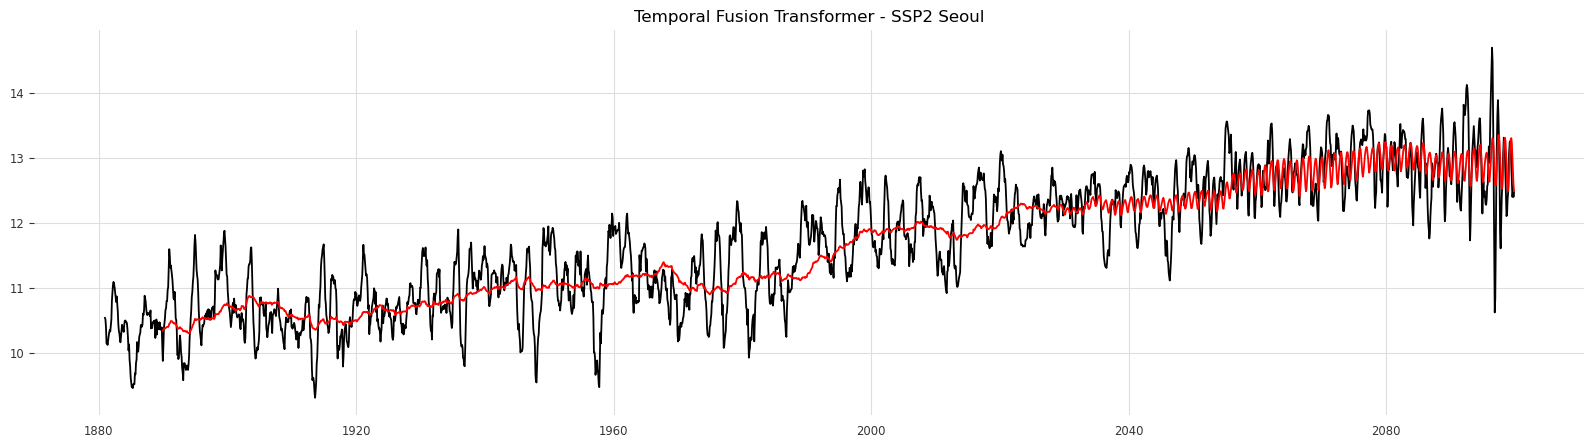

In [17]:
plt.figure(figsize=(20,5))
plt.plot(total.index,month12_ma)
plt.plot(total.index,year10_ma, color='red')
plt.title('Temporal Fusion Transformer - SSP2 Seoul')